In [166]:
import pandas as pd
import plotnine as p9
import numpy as np

data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")

In [71]:
from datetime import datetime as dt
from datetime import timedelta as td

class Antibiotic:


    def __init__(self, info):

        self.name = info[0].capitalize()
        self.activity = info[2].upper() if info[2] != "nan" else ""
        self.start = info[4]
        self.end = info[5]

        self.reformatDate()
        self.reformatActivity()


    @property
    def duration(self):
        return (self.end - self.start).days + 1


    def reformatActivity(self):

        if self.activity:

            if self.activity in ["I", "S", "NR", "SUSC", "SUSCEPTIBLE", "SUSCPETIBLE"]:
                self.activity = "S"

            elif self.activity == "R":
                pass

            else:
                print(self.activity)
                raise ValueError

        else: self.activity = "S"

    def reformatDate(self):

        if "-" in self.start:
            self.start = dt.strptime(self.start, "%Y-%m-%d")
        elif "/" in self.start:
            self.start = dt.strptime(self.start, "%d/%m/%Y")

        if "-" in self.end:
            self.end = dt.strptime(self.end, "%Y-%m-%d")
        elif "/" in self.end:
            self.end = dt.strptime(self.end, "%d/%m/%Y")

        self.duration = (self.end - self.start).days + 1

    def __str__(self):

        return f"{self.name}: {self.activity}\n\t{self.start} -> {self.end}"

    def __repr__(self) -> str:

        return str(self)



class Patient:


    def __init__(self, info):

        self.extractInfo(info)


    def extractInfo(self, info):


        for column in info.index:
            value = info[column]

            if "ATB" not in column: setattr(self, column.lower(), value.lower() if isinstance(value, str) else value)


        columns = info.index[18:]

        self.treatment = []
        for index, column in enumerate(columns[::7]):

            antibioticInfo = [f"{info[aux]}" for aux in columns[index * 7 : index * 7 + 7]]

            if antibioticInfo[0] != "nan":
                self.treatment.append(Antibiotic(antibioticInfo))


    @property
    def dates(self):

        dates = []

        for atb in self.treatment:
            dates.append(atb.start)
            dates.append(atb.end)

        dates.sort()

        return dates


    @property
    def firstDay(self): return self.dates[0]


    @property
    def lastDay(self): return self.dates[-1]


    @property
    def treatmentDuration(self): return (self.lastDay - self.firstDay).days + 1


    @property
    def treatmentLine(self):

        timeline = []
        for index, date in enumerate((self.firstDay + td(n) for n in range(self.treatmentDuration))):

            for atb in self.treatment:

                if atb.start <= date <= atb.end:

                    try:
                        timeline[index].add(f"{atb.name}_{atb.activity}")
                    except IndexError:
                        timeline.append({f"{atb.name}_{atb.activity}"})

        return timeline


    @property
    def condensedTreatmentLine(self):

        timeline = []

        for date in self.treatmentLine:

            try:
                if date != timeline[-1]:
                    timeline.append(date)

            except IndexError:
                timeline.append(date)

        return timeline


    @property
    def changesTratmentLine(self):

        timeline = []

        for date in self.condensedTreatmentLine:

            aux = set()

            for atb in date:
                if "_R" in atb: aux.add("Inactive")
                else: aux.add(atb[:-2])

            timeline.append(aux)

        return timeline




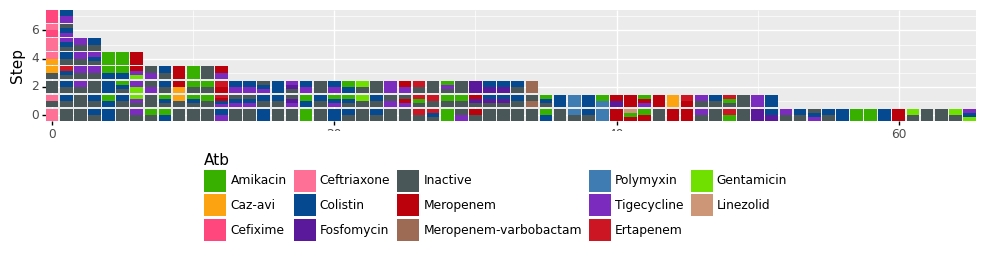

<ggplot: (8783834303552)>

In [67]:
import pandas as pd
import plotnine as p9
import numpy as np
from datetime import datetime, timedelta
from plotnine import *

def generatePlot(info, width = 0.9, height = 0.9):

    palette = {"Caz-avi"               : "#fca311", # CAZAVI   amarrillo
               "Inactive"              : "#4a5759", # Inactivo gris
               "Amikacin"              : "#38b000", # Aminoglicosidos verde
               "Gentamicin"            : "#70e000", # Aminoglicosidos verde
               "Meropenem"             : "#bb010b", # Carbapenemicos rojo
               "Ertapenem"             : "#cd1624", # Carbapenemicos rojo
               "Cefixime"              : "#ff477e", # Cefalosporinas rosa
               "Ceftazidime"           : "#ff5c8a", # Cefalosporinas rosa
               "Ceftriaxone"           : "#ff7096", # Cefalosporinas rosa
               "Colistin"              : "#054a91", # Polimixinas
               "Polymyxin"             : "#3e7cb1", # Polimixinas
               "Ciprofloxacin"         : "#81171b", # Quinolonas burdeos
               "Levofloxacin"          : "#ad2e24", # Quinolonas burdeos
               "Fosfomycin"            : "#5a189a", # Sin grupo (grande) morado
               "Tigecycline"           : "#7b2cbf", # Sin grupo (grande) morado
               "Tmp/smx"               : "#8a5a44", # Sin grupo (pequeño) marrón
               "Meropenem-varbobactam" : "#9d6b53", # Sin grupo (pequeño) marrón
               "Metronidazole"         : "#b07d62", # Sin grupo (pequeño) marrón
               "Daptomycin"            : "#c38e70", # Sin grupo (pequeño) marrón
               "Linezolid"             : "#cd9777"  # Sin grupo (pequeño) marrón
               }


    names = list(palette.keys())

    maximum = []

    allAtbs = set()
    for patient in info:
        for step in patient.changesTratmentLine:
            maximum.append(len(step))
            for atb in step:
                allAtbs.add(atb)

    for name in names:
        if name not in allAtbs:
            del palette[name]

    maximum = max(maximum)

    res = {}

    for i in range(1, maximum + 1):
        for j in range(i):
            try:
                res[i][j] = pd.DataFrame(columns = ["Pt", "Atb", "Step"])
            except KeyError:
                res[i] = {j : pd.DataFrame(columns = ["Pt", "Atb", "Step"])}


    # Ordena pacientes de menos cambios a más cambios
    info.sort(key = lambda x: len(x.changesTratmentLine), reverse = True)

    for indexPt, patient in enumerate(info):

        for indexStep, step in enumerate(patient.changesTratmentLine):
            for n, atb in enumerate(step):

                if n != 0:

                    primeWidth = height / len(step) * (len(step) - n)

                    floor = indexStep - (height / 2)

                    primeCenter = floor + (primeWidth / 2)

                else:
                    primeCenter = indexStep

                res[len(step)][n].loc[len(res[len(step)][n].index)] = [indexPt,
                                                                       atb,
                                                                       primeCenter]

    plot = ["ggplot(aes('Pt', 'Step'))",
            "aes(fill = 'Atb')"]


    for i in res:
        for j in res[i]:

            if j == 0:
                plot.append(f"geom_tile(res[{i}][{j}], aes(width = width, height = height))")

            else:
                plot.append(f"geom_tile(res[{i}][{j}], aes(width = width, height = height / {i} * {i - j}))")


    plot.append("scale_fill_manual(palette)")
    plot.append("coord_equal(expand = False)")
    plot.append("theme(figure_size = (12, 20))")
    plot.append("theme(legend_position = 'bottom')")

    return eval(" + ".join(plot))



data = pd.read_csv("./test/database/treatment.csv",
                   sep = "\t")
data = data[data["Cohort_Treatment"] == "yes"]
data = data[data["Cohort_Cazavi"] == "no"]

patients = []
for index, row in data.iterrows():
    patients.append(Patient(row))

generatePlot(patients)


In [73]:
for patient in patients:
    if "Caz-avi" in [atb.name for atb in patient.treatment]:
        print(patient.pt)
        print([f"{atb.name}_{atb.activity}" for atb in patient.treatment])
        for atb in patient.treatment:
            if atb.name == "Caz-avi":
                print(atb.duration)
        print(".........")

116
['Ceftriaxone_S', 'Ertapenem_R', 'Caz-avi_S', 'Ceftriaxone_S', 'Cefixime_S']
2
.........
46
['Piperacilin-tazobactam_R', 'Caz-avi_S', 'Meropenem_S']
2
.........
125
['Meropenem_S', 'Meropenem_S', 'Meropenem_S', 'Meropenem_S', 'Caz-avi_S', 'Caz-avi_S']
4
12
.........
47
['Caz-avi_R', 'Aztreonam_R', 'Colistin_S']
16
.........
